In [1]:
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle

import os

Want array’s of  [list of particle 4-vectors(pt, mass, eta, phi), z_leading, theta] to feed into RNN or 1D CNN.

In [2]:
addPerturbation = True

In [3]:
def partition_exp(n_particles=10, nevents=1, mu=1.):
    evals = np.random.exponential(scale = mu, size=(nevents,n_particles))
    sumRow =np.repeat(evals.sum(axis=1), n_particles).reshape(nevents, n_particles)
    evals = np.sort(np.divide(evals,sumRow))[:, ::-1]
    return evals

In [4]:
def makeFourVectors(n_events = 10, n_particles = 5, isSignal = False, overlap = 0):
    labels = np.zeros(shape=(n_events,2))
    
    zloc = 0.5
    theta_loc = 0.2
    pt_factor = 1.
    if(addPerturbation):
        zloc = 0.5
        theta_loc = 0.1
        pt_factor = 0.5
    
        # create input variables
    if isSignal:
        if (overlap==0):
            theta = np.random.normal(loc=theta_loc, scale=0.02, size=n_events) # signal_d
            z = np.random.normal(loc=zloc, scale=0.02, size=n_events) #signal_z 
        elif(overlap==1):
            theta = np.random.normal(loc=theta_loc, scale=0.03, size=n_events) # signal_d_littleoverlap
            z = np.random.normal(loc=zloc, scale=0.09, size=n_events) #signal_z_littleoverlap
        elif(overlap==2):
            theta = np.random.normal(loc=theta_loc, scale=0.05, size=n_events) # signal_d_overlap
            z = np.random.normal(loc=zloc, scale=0.12, size=n_events) #signal_z_overlap
        pt = np.random.exponential(scale = 1/0.01, size = (n_events, n_particles))*pt_factor
        mass = 0.936*np.random.normal(loc = 39.5, scale = 18.3, size = (n_events,n_particles))
        eta = 1.1*np.random.normal(loc = 0.0, scale = 1.4, size = (n_events,n_particles))
        phi = np.random.uniform(-3.14,3.14,(n_events, n_particles))
        labels[:,1]=1
    else:
        if (overlap==0):
            theta = np.random.exponential(scale=0.02, size=n_events) # bkg_d
            z = np.random.exponential(scale=0.02, size=n_events) #bkg_z
        elif(overlap==1):
            theta = np.random.exponential(scale=0.03, size=n_events) # bkg_d_littleoverlap
            z = np.random.exponential(scale=0.1, size=n_events) #bkg_z_olittleverlap
        elif(overlap==2):
            theta = np.random.exponential(scale=0.05, size=n_events) # bkg_d_overlap
            z = np.random.exponential(scale=0.15, size=n_events) #bkg_z_overlap
        pt = np.random.exponential(scale=1/0.002675, size = (n_events, n_particles))
        mass = np.random.exponential(scale=1/0.011082, size = (n_events, n_particles))
        eta = 1.008*np.random.normal(loc = 0.001913, scale = 1.811, size = (n_events, n_particles))
        phi = np.random.uniform(-3.14,3.14,size = (n_events, n_particles))
        labels[:,0]=1
        
        
    print(labels)
    
    # masking z to ensure z<1.0
    z = np.where(z<1.0, z, z%1) #signal_z   
    # making so that z is always more than 1-z
    z = np.where(z>0.5, z, (1-z))
    
    mass = np.where(mass>0., mass, mass+20.)
    
    z = np.repeat(z, n_particles).reshape(n_events, n_particles)
    # masking theta to ensure theta<0.5
    theta = np.where(theta<0.5, theta, theta%0.5)
    theta = np.repeat(theta, n_particles).reshape(n_events, n_particles)
    
    # distributing pT fractions between particles
    particles1 = np.multiply(partition_exp(n_particles, n_events), z)
    particles2 = np.multiply(partition_exp(n_particles, n_events), (1-z))
    
    
    # one jet has two subjets 
    radii = np.random.uniform(0.25,0.5 ,size = (n_events,2))
    radii1 = np.array([np.multiply(np.ones(shape = int(n_particles/2)),y) for y in radii[:,0]])
    radii2 = np.array([np.multiply(np.ones(shape = int(n_particles/2)),y) for y in radii[:,1]])
    dtheta1 = np.random.exponential(scale=0.5, size=(n_events, int(n_particles/2))) # delta theta for first subjet
    dtheta1= np.sort(np.where(dtheta1<radii1, dtheta1, dtheta1%radii1))
    phi1 = np.random.uniform(0, 2*math.pi, size=(n_events, int(n_particles/2))) # angular
    dtheta2 = np.random.exponential(scale=0.5, size=(n_events, int(n_particles/2))) # delta theta for second subjet
    dtheta2= np.sort(np.where(dtheta2<radii2, dtheta2, dtheta2%radii2))
    phi2 = np.random.uniform(0, 2*math.pi, size=(n_events, int(n_particles/2))) # angular
    
    z = z.reshape(n_events,n_particles)
    theta = theta.reshape(n_events,n_particles)
    radii = np.concatenate((radii1, radii2), axis = 1)
    return pt, eta, mass, phi, radii, z, theta, labels

Load some pythia data and fit to get idea of signal vs. background distribution to make a nice toy model

In [5]:
n_events = 10000
n_particles = 10
tic = time.perf_counter()
isSignal1 = True
overlap = 1
pt1, eta1, mass1, phi1, radii1, z1, theta1, labels1 = makeFourVectors(n_events, n_particles, isSignal1, overlap)
features1 = [pt1, eta1, mass1, phi1, radii1, z1, theta1]
print(pt1.shape, mass1.shape, phi1.shape, radii1.shape, z1.shape, theta1.shape, labels1.shape)
toc = time.perf_counter()
print('Processing Time is ',toc-tic, 'seconds for ',n_events, ' samples.' )

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
(10000, 10) (10000, 10) (10000, 10) (10000, 10) (10000, 10) (10000, 10) (10000, 2)
Processing Time is  0.14386971667408943 seconds for  10000  samples.


In [6]:
tic = time.perf_counter()
isSignal2 = False
pt2, eta2, mass2, phi2, radii2, z2, theta2, labels2= makeFourVectors(n_events, n_particles, isSignal2, overlap)
features2 = [pt2, eta2, mass2, phi2, radii2, z2, theta2]
toc = time.perf_counter()
print('Processing Time is ',toc-tic, 'seconds for ',n_events, ' samples.' )

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
Processing Time is  0.14106817170977592 seconds for  10000  samples.


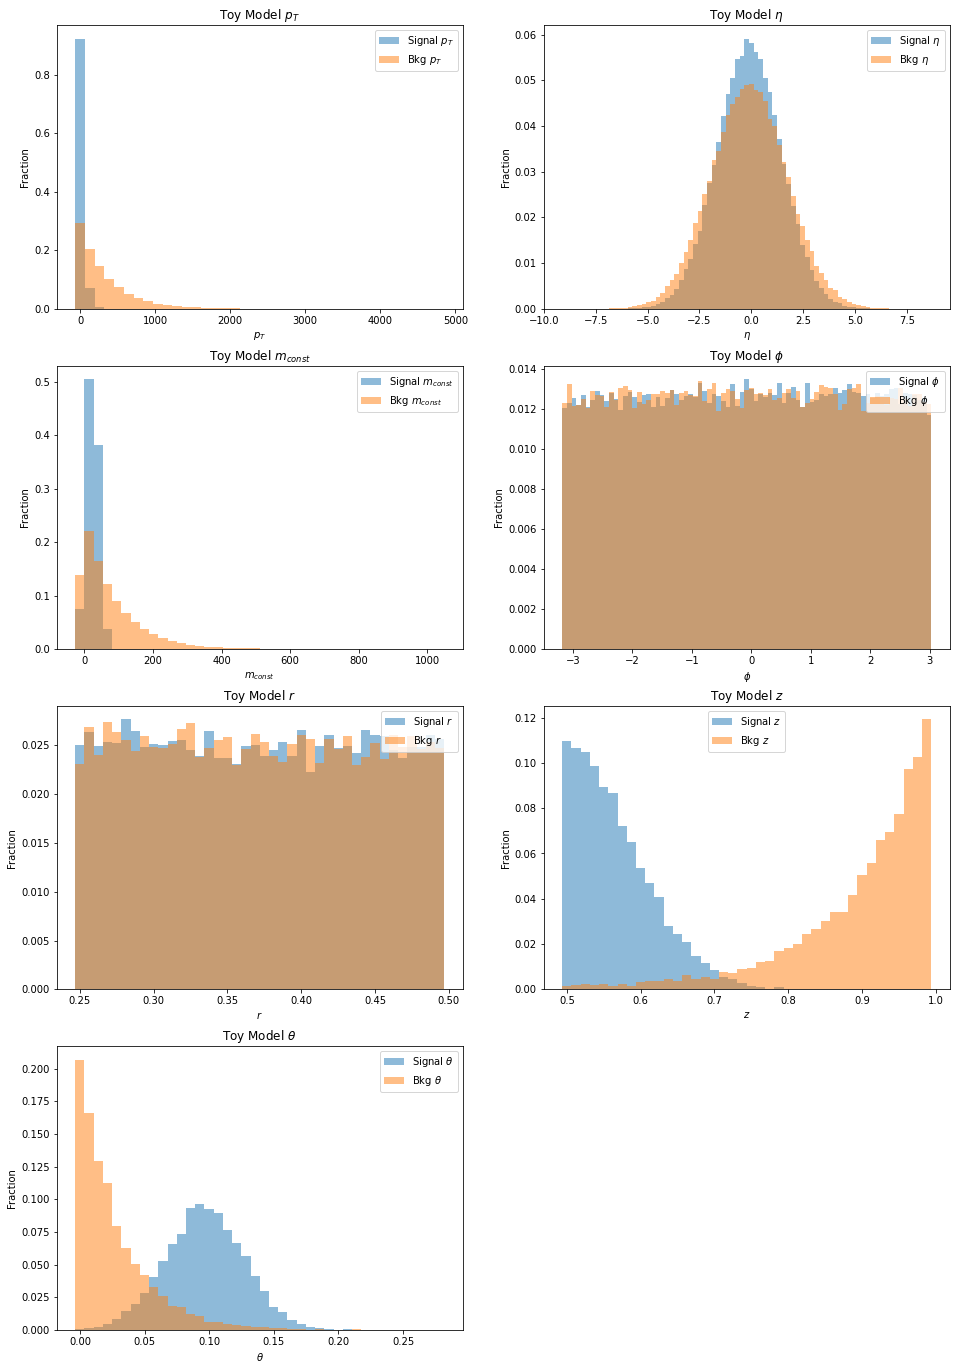

In [7]:
names = [r'$p_T$', r'$\eta$', r'$m_{const}$', r'$\phi$', r'$r$', r'$z$', r'$\theta$' ]
ptbin = [0, 1.29387446e+02, 2.58773873e+02, 3.88160301e+02,
       5.17546729e+02, 6.46933157e+02, 7.76319584e+02, 9.05706012e+02,
       1.03509244e+03, 1.16447887e+03, 1.29386530e+03, 1.42325172e+03,
       1.55263815e+03, 1.68202458e+03, 1.81141101e+03, 1.94079743e+03,
       2.07018386e+03, 2.19957029e+03, 2.32895672e+03, 2.45834314e+03,
       2.58772957e+03, 2.71711600e+03, 2.84650243e+03, 2.97588886e+03,
       3.10527528e+03, 3.23466171e+03, 3.36404814e+03, 3.49343457e+03,
       3.62282099e+03, 3.75220742e+03, 3.88159385e+03, 4.01098028e+03,
       4.14036670e+03, 4.26975313e+03, 4.39913956e+03, 4.52852599e+03,
       4.65791242e+03, 4.78729884e+03, 4.91668527e+03]
etabin = np.arange(-9, 9, 9/40)
mbin = [ -13.41506045,   13.49889596,   40.41285237,   67.32680877,
         94.24076518,  121.15472159,  148.068678  ,  174.9826344 ,
        201.89659081,  228.81054722,  255.72450362,  282.63846003,
        309.55241644,  336.46637284,  363.38032925,  390.29428566,
        417.20824206,  444.12219847,  471.03615488,  497.95011128,
        524.86406769,  551.7780241 ,  578.6919805 ,  605.60593691,
        632.51989332,  659.43384972,  686.34780613,  713.26176254,
        740.17571895,  767.08967535,  794.00363176,  820.91758817,
        847.83154457,  874.74550098,  901.65945739,  928.57341379,
        955.4873702 ,  982.40132661, 1009.31528301, 1036.22923942,
       1063.14319583]
phibin = np.arange(-np.pi, np.pi, np.pi/40)
thetabin = [1.11248276e-06, 7.13714472e-03, 1.42731770e-02, 2.14092092e-02,
       2.85452414e-02, 3.56812737e-02, 4.28173059e-02, 4.99533381e-02,
       5.70893704e-02, 6.42254026e-02, 7.13614348e-02, 7.84974671e-02,
       8.56334993e-02, 9.27695316e-02, 9.99055638e-02, 1.07041596e-01,
       1.14177628e-01, 1.21313660e-01, 1.28449693e-01, 1.35585725e-01,
       1.42721757e-01, 1.49857789e-01, 1.56993822e-01, 1.64129854e-01,
       1.71265886e-01, 1.78401918e-01, 1.85537951e-01, 1.92673983e-01,
       1.99810015e-01, 2.06946047e-01, 2.14082080e-01, 2.21218112e-01,
       2.28354144e-01, 2.35490176e-01, 2.42626209e-01, 2.49762241e-01,
       2.56898273e-01, 2.64034305e-01, 2.71170337e-01, 2.78306370e-01,
       2.85442402e-01]
zbin = [0.50000224, 0.51250213, 0.52500201, 0.5375019 , 0.55000179,
       0.56250167, 0.57500156, 0.58750145, 0.60000133, 0.61250122,
       0.62500111, 0.63750099, 0.65000088, 0.66250077, 0.67500065,
       0.68750054, 0.70000043, 0.71250031, 0.7250002 , 0.73750009,
       0.74999997, 0.76249986, 0.77499975, 0.78749963, 0.79999952,
       0.81249941, 0.82499929, 0.83749918, 0.84999907, 0.86249895,
       0.87499884, 0.88749873, 0.89999861, 0.9124985 , 0.92499839,
       0.93749827, 0.94999816, 0.96249805, 0.97499793, 0.98749782,
       0.99999771]
rbin = [0.2500161 , 0.25626493, 0.26251377, 0.2687626 , 0.27501144,
       0.28126027, 0.28750911, 0.29375794, 0.30000678, 0.30625561,
       0.31250445, 0.31875328, 0.32500212, 0.33125095, 0.33749979,
       0.34374862, 0.34999746, 0.35624629, 0.36249513, 0.36874396,
       0.3749928 , 0.38124163, 0.38749047, 0.3937393 , 0.39998814,
       0.40623697, 0.41248581, 0.41873464, 0.42498348, 0.43123231,
       0.43748115, 0.44372998, 0.44997882, 0.45622765, 0.46247649,
       0.46872532, 0.47497416, 0.48122299, 0.48747183, 0.49372066,
       0.4999695 ]
bins = [ptbin, etabin, mbin, phibin, rbin, zbin, thetabin]
plt.figure(figsize = (16,24))
for i in np.arange(len(features1)):
    plt.subplot(int(len(features1)/2)+1,2,(i+1))
    hist1, bins1 = np.histogram(features1[i], bins=bins[i])
    hist2, bins2 = np.histogram(features2[i], bins=bins1)
    plt.bar(bins1[:-1], hist1/(np.sum(hist1)), width=np.diff(bins1), alpha = 0.5, label = "Signal " + names[i])
    plt.bar(bins2[:-1], hist2/(np.sum(hist2)), width=np.diff(bins2), alpha = 0.5, label = "Bkg "+names[i])
    plt.xlabel(names[i])
    plt.ylabel("Fraction")
    legend = plt.legend()
    plt.title("Toy Model "+names[i])

In [8]:
tic = time.perf_counter()
isSignal3 = True
pt3, eta3, mass3, phi3, radii3, z3, theta3, labels3= makeFourVectors(n_events, n_particles, isSignal3, overlap)
toc = time.perf_counter()
fourvectors3 = np.array([pt3, eta3, mass3, phi3])
fourvectors3 = fourvectors3.reshape(n_events, n_particles, 4)
print('Processing Time is ',toc-tic, 'seconds for ',n_events, ' samples.' )
np.savez('data/dummyvectors_sgn_test', pt = pt3, eta = eta3, phi = phi3, mass = mass3, radiilab = radii3, zlab = z3, thetalab = theta3, labels = labels3)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Processing Time is  0.1476283259689808 seconds for  10000  samples.


In [9]:
tic = time.perf_counter()
isSignal4 = False
pt4, eta4, mass4, phi4, radii4, z4, theta4, labels4= makeFourVectors(n_events, n_particles, isSignal4, overlap)
toc = time.perf_counter()
fourvectors4 = np.array([pt4, eta4, mass4, phi4])
fourvectors4 = fourvectors4.reshape(n_events, n_particles, 4)
print('Processing Time is ',toc-tic, 'seconds for ',n_events, ' samples.' )
np.savez('data/dummyvectors_bkg_test', pt = pt4, eta = eta4, phi = phi4, mass = mass4, radiilab = radii4, zlab = z4, thetalab = theta4, labels = labels4)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
Processing Time is  0.15909426659345627 seconds for  10000  samples.


### Concatenate signal and bg together, shuffle, and save files

In [10]:
trainlabels = np.concatenate((labels1,labels2),axis=0)
n_train = len(trainlabels)
train_pt = np.concatenate((pt1, pt2), axis = 0)
batch = np.size(train_pt, 1)
train_pt = train_pt.reshape(n_train, batch, 1)
train_eta = np.concatenate((eta1, eta2), axis = 0).reshape(n_train, batch, 1)
train_phi = np.concatenate((phi1, phi2), axis = 0).reshape(n_train, batch, 1)
train_mass = np.concatenate((mass1, mass2), axis = 0).reshape(n_train, batch, 1)
train_r = np.concatenate((radii1, radii2), axis = 0)
train_theta = np.concatenate((theta1, theta2), axis = 0)
train_z = np.concatenate((z1, z2), axis = 0)
train_labels = trainlabels.reshape(n_train, 2)
# testing data
testlabels = np.concatenate((labels3, labels4),axis=0)
n_test = len(testlabels)
test_pt = np.concatenate((pt3, pt4), axis = 0)
batch = np.size(test_pt, 1)
test_pt = test_pt.reshape(n_test, batch, 1)
test_eta = np.concatenate((eta3, eta4), axis = 0).reshape(n_test, batch, 1)
test_phi = np.concatenate((phi3, phi4), axis = 0).reshape(n_test, batch, 1)
test_mass = np.concatenate((mass3, mass4), axis = 0).reshape(n_test, batch, 1)
test_r = np.concatenate((radii3, radii4), axis = 0)
test_theta = np.concatenate((theta3, theta4), axis = 0)
test_z = np.concatenate((z3, z4), axis = 0)
test_labels = testlabels.reshape(int(n_test), 2)
print(test_labels)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [11]:
train_id = np.random.permutation(len(train_labels))
test_id = np.random.permutation(len(test_labels))
print(np.max(train_pt))
train_features = [train_pt, train_eta, train_phi, train_mass, train_theta, train_r, train_z, train_labels]
test_features = [test_pt, test_eta, test_phi, test_mass, test_theta, test_r, test_z, test_labels]
for i in np.arange(len(train_features)):
    train_features[i] = train_features[i][train_id]
    test_features[i] = test_features[i][test_id]
print(np.max(train_features[0]))
print(test_features[-1])

3943.8558878096783
3943.8558878096783
[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


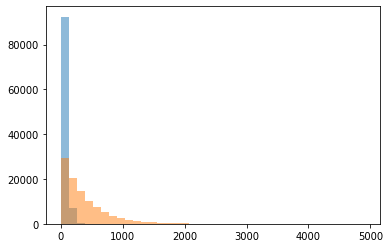

In [12]:
sig = (train_features[-1][:,0]==0)
bkg = (train_features[-1][:,0]==1)

plt.hist(train_features[0][sig].flatten(), bins=bins[0], alpha=0.5)
plt.hist(train_features[0][bkg].flatten(), bins=bins[0], alpha=0.5)
plt.show()

In [13]:

ext = ''
if(addPerturbation):
    ext='_perturb'

filename_train = 'data/jetConstTrain_overlap'+ext
filename_test = 'data/jetConstTest_overlap'+ext

np.savez(filename_train, pt = train_features[0], eta = train_features[1], phi = train_features[2], mass = train_features[3], thetalab = train_features[4], radiilab = train_features[5], zlab = train_features[6], labels = train_features[7])
np.savez(filename_test, pt = test_features[0], eta = test_features[1], phi = test_features[2], mass = test_features[3], thetalab = test_features[4], radiilab = test_features[5], zlab = test_features[6], labels = test_features[7])

print(filename_test+'.npz')

data/jetConstTest_overlap_perturb.npz


In [14]:
test_features[7]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [15]:
test_features[-1]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])